---
# Time series anomaly detection

Depending on available data, there are a lot of approaches for anomaly detection. If **data is labeled** (each point in time has a label anomaly / not anomaly, then supervised learning approaches can be used. Thus, it is a classification task where logistic regression, random forest, SVM, boosting, RNN, etc. can be applied. Here you have to pay attention to:
1. Data imbalance because usually there are just a few anomalies (less than 5% of all available data) and 
2. [Cross validation through time](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In case **labels are not provided**, other unsupervised techniques should be applied. There are also several methods for anomaly detection, but the general approach is quite similar: predict a value and compare it with a realized value. And if the residual is more or less than some threshold, then it is an anomaly.

There are several methods to make a prediction: moving average (simple, weighted) taking into account the last few hours or days or weekdays, etc., ARIMA model, Prophet, [seasonal Hybrid Extreme Studentized Deviate](https://arxiv.org/pdf/1704.07706.pdf) technique and many others.

In this notebook, we are going to use a moving average for prediction and 1.5 standard deviations as a threshold.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---
# Data load and preparation

Data is prepared in the [Notebook](./exploratory_data_analysis.ipynb) and pickled. Thus, we can load and visualize the already prepared hourly CTR time series.

In [2]:
data_set = pd.read_pickle('./data/CTR_aggregated.pkl')
data_set.index = data_set.hour
data_set.drop(columns='hour', inplace=True)

Text(0.5, 1.0, 'Hourly CTR for period  2014/10/21 and 2014/10/30')

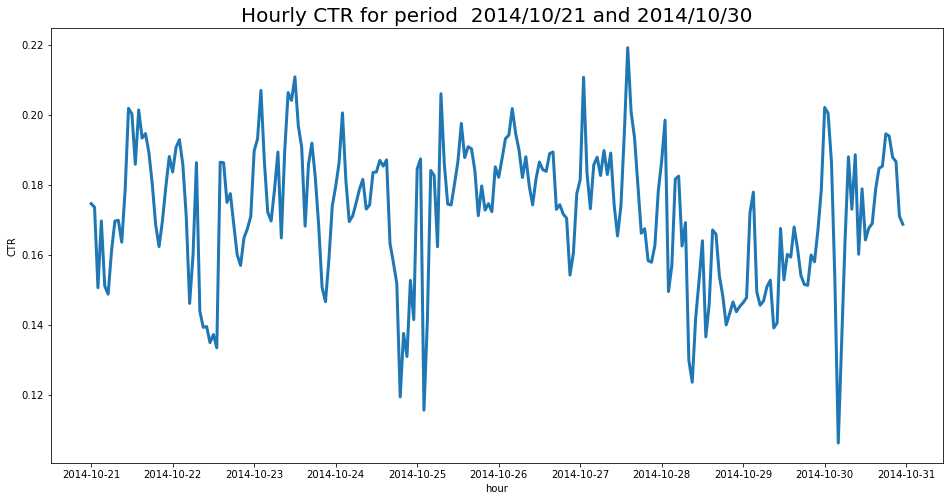

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=[16, 8])
sns.lineplot(x='hour', y='CTR', data=data_set, linewidth=3)
plt.title('Hourly CTR for period  2014/10/21 and 2014/10/30', fontsize=20)

---
# Anomay detection by Simple Moving Average approach

Here we are using `pandas` functions `shift` and `rolling` for rolling lag `mean` and `std` calculation. 24 hour window is used for moving average and moving standart deviation calculations. The assumption here is that the values of the last day are supposed to be close to the current day.

In [4]:
def plot_anmolies(data, period=24):
    """
    Function takes data and period for MA and plots time seies with MA prediction and boundaries
    """

    # MA calculation
    data['MA'] = data.CTR.shift(1).rolling(period).mean()
    data['STD'] = data.CTR.shift(1).rolling(period).std()
    data[['UpperBoundary']] = data['MA'] + 1.5 * data['STD']
    data[['LowerBoundary']] = data['MA'] - 1.5 * data['STD']
    data['Anomaly'] = np.where(
        abs(data['MA'] - data['CTR']) > 1.5 * data['STD'], 'Anomaly',
        'Not anomaly')

    # plot anomalies
    plt.figure(figsize=[16, 8])
    sns.lineplot(x='hour',
                 y='CTR',
                 data=data,
                 linewidth=3,
                 label='CTR',
                 color='lightblue')
    sns.lineplot(x='hour', y='MA', data=data, linewidth=3, label='MA')
    sns.lineplot(x='hour',
                 y='UpperBoundary',
                 data=data,
                 linewidth=3,
                 color='grey',
                 label='UpperBoundary')
    sns.lineplot(x='hour',
                 y='LowerBoundary',
                 data=data,
                 linewidth=3,
                 color='grey',
                 label='LowerBoundary')

    sns.scatterplot(x='hour',
                    y='CTR',
                    data=data,
                    hue='Anomaly',
                    s=100,
                    palette=['lightblue', 'red'])

    plt.title(
        "CTR hourly Anomaly Detection with {}-period rolling window Moving Average\nFound {} anomalies in {} data point. {} points are excluded to build moving a average."
        .format(period,
                sum(data['Anomaly'] == 'Anomaly'),
                data['MA'].notna().sum(),
                data['MA'].isna().sum()),
        fontsize=20)
    plt.tight_layout()

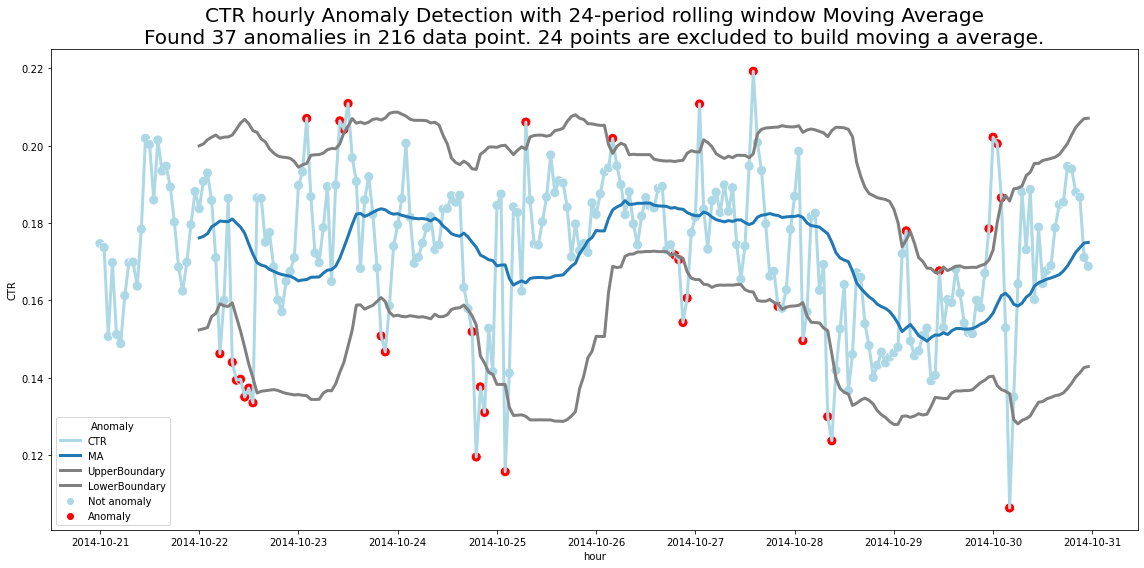

In [5]:
plot_anmolies(data_set, 24)

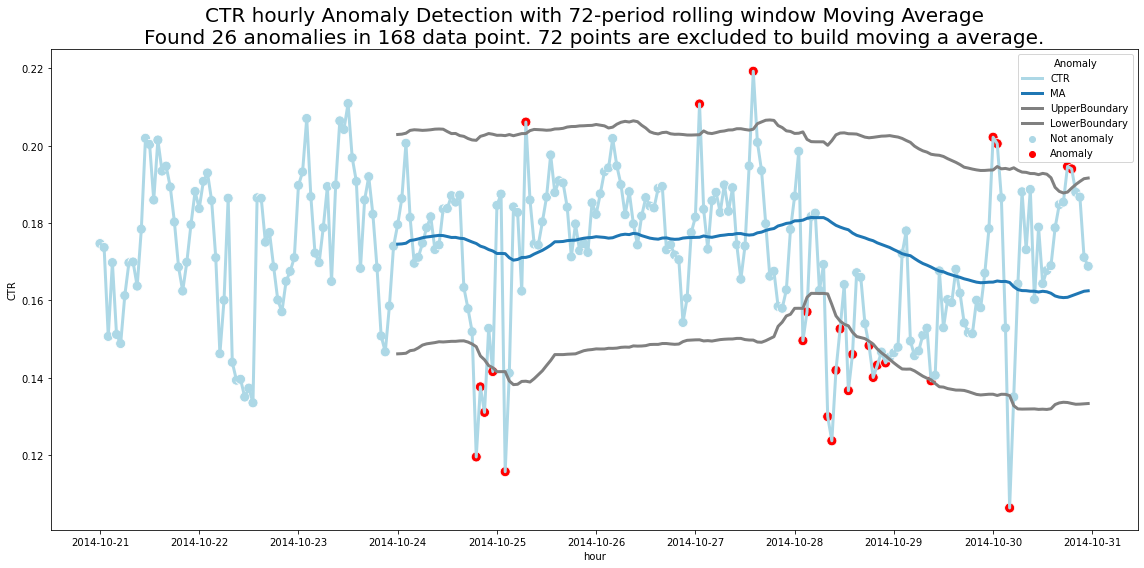

In [6]:
plot_anmolies(data_set, 72)

---
# Summary

Simple Moving Approach works quite well for anomay detection.  By varying `period` value in `plot_anmolies` function, you can try to find the optimal period value. But given the nature of the data, I recommend using a period as a multiple of 24. If you would like to find less and more robust anomalies, use period 48, 72 or more.

Other approaches can be considered in the next steps: EMA, ARIMA taking into account hourly and weekly seasonality, Prophet, etc.